## Frequency deviation adjustments
Adjust the frequency deviation signal so that it falls within the uncertainty set defined by the European Commission and investigate the difference between the original and the adjusted signal.

In [2]:
# -- import relevant python libraries
# data analysis
import pandas as pd
import numpy as np
from gurobipy import *
# static plotting
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
# interactive plotting
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

Define the functions `find_gmm_emp` and `adjust_delta`

In [5]:
def find_gmm_emp(delta10s, Gmm = 2.5, dt = 0.5,
                 T_days = pd.date_range('01-01-2015 00:00:00', '12-31-2019', freq='D')):
    """
    find_gmm_emp(delta10s, Gmm = 2.5, dt = 0.5, T = 24,
                 T_days = pd.date_range('01-01-2015 00:00:00', '12-31-2019', freq='D'))
    finds the minimum empirical activation period given regulation cycle Gmm for each day in T_years
    
    INPUTS:
        delta10s: normalized frequency deviation signal with 10s resolution
        Gmm:      regulation cycle (hour)
        dt:       time discretization interval (hour)
        T_days:  days to consider
        
    OUTPUTS:
        dltadj: adjusted regulation signal 
    """
    # resample frequency deviation data
    delta = delta10s.abs()
    delta = delta.resample('30min').mean()
    # define problem parameters
    K = round(24/dt)    # planning horizon (periods)
    # declare result dataframe
    gmm_emp = pd.DataFrame(index = T_days, columns = ['gmm_emp'])
    # calculate empirical gamma on each day
    for t_day in T_days:
        # expand time to a half-hourly resolution
        t = pd.date_range(t_day, periods = K, freq='30min')
        # extract frequency deviations for that day
        dlt = delta.loc[t, 'delta'].values
        # set-up a minimization model
        m = Model("gmm_emp")
        m.ModelSense = 1
        # define the decision variable
        gmm = m.addVar(lb=0, obj=1, name="gmm")
        # ... and the constraints
        m.addConstrs( (quicksum( dlt[i] \
                        for i in range( max(0, l+1 - round(Gmm/dt)), l+1)) \
                        <= gmm/dt for l in range(K)), "D" )
        # disable logging to screen
        m.Params.OutputFlag = 0
        # optimize
        m.optimize()
        # store result
        gmm_emp.loc[t_day, 'gmm_emp'] = gmm.X
    # return result dataframe
    return gmm_emp

def adjust_delta(gmm_emp, gmm, Gmm):
    """
    adjust_delta(gmm_emp, gmm, Gmm)
    adjusts delta in a causal way to fit into the uncertainty set defined by gmm and Gmm
    
    INPUTS:
        gmm_emp: empirical daily min. activation period with regulation cycle Gmm
        gmm: desired activation period (hour)
        Gmm: regulation cycle (hour)
        
    OUTPUTS:
        dltadj: adjusted regulation signal with 10s resolution
    """
    # define 10s time resolution
    ddt = 1/360
    
    # import raw data
    dlt10s = pd.read_hdf('delta_10s.h5')
    
    # define the adjusted signal
    dltadj = dlt10s 
    
    # find the days outside the uncertainty set
    T = gmm_emp[gmm_emp['gmm_emp'] > gmm].index
    
    # loop over these days
    for t_day in T:
        # expand time to a 10s resolution
        t = pd.date_range(t_day, periods = 24/ddt, freq='10s')
        # extract frequency deviations for that day
        dlt = dlt10s.loc[t,'delta'].values
        # loop over all time periods within the day 
        for k in range(len(dlt)):
            # reduce the deviation from zero if necessary
            dev = sum( abs(dlt[i]) for i in range( max(0, k+1 - round(Gmm/ddt)), k+1))
            if dev > gmm/ddt:
                dlt[k] = np.sign(dlt[k]) * (gmm/ddt - dev + abs(dlt[k]))
        # assign the adjusted signal
        dltadj.loc[t, 'delta'] = dlt
    # return result
    return dltadj

Calculate the empirical activation period for the original dataset using `find_gmm_emp`

In [8]:
gmm_emp_2pt5hours = find_gmm_emp(pd.read_hdf('delta_10s.h5'), Gmm = 2.5)
gmm_emp_5hours = find_gmm_emp(pd.read_hdf('delta_10s.h5'), Gmm = 5)

Adjust the frequency signal in a causal way so that it fits into the uncertainty sets defined by $\gamma$ and $\Gamma$ (Warning: this may take several hours)

In [ ]:
dlt_2pt5hours = adjust_delta(gmm_emp_2pt5hours, gmm = 0.5, Gmm = 2.5)
dlt_5hours = adjust_delta(gmm_emp_5hours, gmm = 0.5, Gmm = 5)
# store the results
dlt_2pt5hours.to_hdf('delta_Gmm_2pt5hours.h5', key='dlt')
dlt_5hours.to_hdf('delta_Gmm_5hours.h5', key='dlt')

Since the step above may take quite a while, load the prepocessed data for further analysis

In [3]:
dlt10s = pd.read_hdf('delta_10s.h5')
dlt_2pt5hours = pd.read_hdf('delta_Gmm_2pt5hours.h5', key = 'dlt')
dlt_5hours = pd.read_hdf('delta_Gmm_5hours.h5', key = 'dlt')

Calculate the empirical activation periods for the adjusted datasets

In [6]:
gmm_emp_2pt5hours_adj = find_gmm_emp(dlt_2pt5hours, Gmm = 2.5)
gmm_emp_5hours_adj = find_gmm_emp(dlt_5hours, Gmm = 5)

Academic license - for non-commercial use only


### Examine the original and adjusted frequency deviation signals

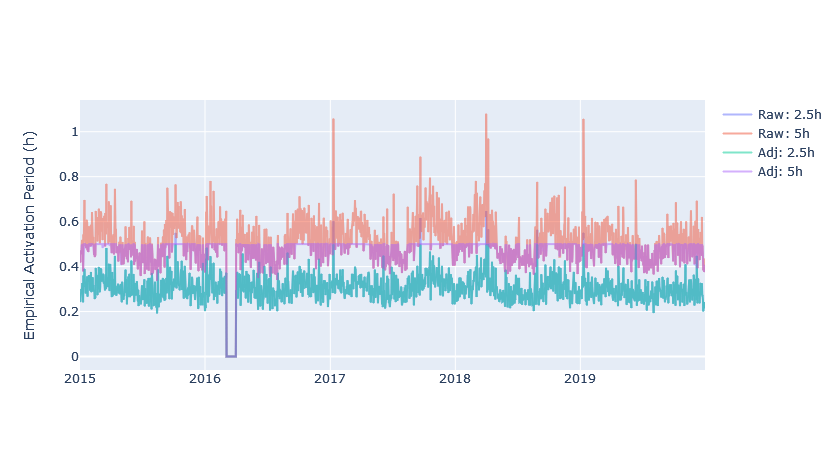

In [9]:
alpha = 0.5
plotly.offline.iplot({
    "data": [go.Scatter(x=gmm_emp_2pt5hours.index, y=gmm_emp_2pt5hours['gmm_emp'], name = 'Raw: 2.5h', opacity = alpha),
            go.Scatter(x=gmm_emp_5hours.index, y=gmm_emp_5hours['gmm_emp'], name = 'Raw: 5h', opacity = alpha),
            go.Scatter(x=gmm_emp_2pt5hours_adj.index, y=gmm_emp_2pt5hours_adj['gmm_emp'], name = 'Adj: 2.5h', opacity = alpha),
            go.Scatter(x=gmm_emp_5hours_adj.index, y=gmm_emp_5hours_adj['gmm_emp'], name = 'Adj: 5h', opacity = alpha)
            ],
    "layout": go.Layout(yaxis=dict(title="Empirical Activation Period (h)"))
})

The original frequency deviation signal falls outside the uncertainty set $\mathcal{D}$ parametrized by $\gamma = 0.5$h and $\Gamma = 2.5$h on nine days from 1 January 2015 to 31 December 2019. If $\gamma$ decreases to 15min, this number increases to 959 out of 1798 days. Note that 2016 was a special year because of missing frequency recordings in March.

In [10]:
gmm_emp_2pt5hours_2015 = gmm_emp_2pt5hours.loc[pd.date_range('01-01-2015 00:00:00', '12-31-2015', freq='D')]
gmm_emp_2pt5hours_2017 = gmm_emp_2pt5hours.loc[pd.date_range('01-01-2017 00:00:00', '12-31-2017', freq='D')]
gmm_emp_2pt5hours_2018 = gmm_emp_2pt5hours.loc[pd.date_range('01-01-2018 00:00:00', '12-31-2018', freq='D')]
gmm_emp_2pt5hours_2019 = gmm_emp_2pt5hours.loc[pd.date_range('01-01-2019 00:00:00', '12-31-2019', freq='D')]

In [ ]:
# Define regulation cycle
Gmm = 2.5
# Set plot parameters
transp = 0.5
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot
fig = plt.figure(figsize=[15, 6])
plt.rcParams.update({'font.size': 20})
plt.axis([0,0.3,0,1])
plt.plot(gmm_emp_2pt5hours_2015.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_2pt5hours_2015)),1,len(gmm_emp_2pt5hours_2015)),\
         label='2015', linewidth=4, alpha = transp, linestyle='--')
plt.plot(gmm_emp_2pt5hours_2017.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_2pt5hours_2017)),1,len(gmm_emp_2pt5hours_2017)),\
         label='2017', linewidth=4, alpha = transp, linestyle=':')
plt.plot(gmm_emp_2pt5hours_2018.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_2pt5hours_2018)),1,len(gmm_emp_2pt5hours_2018)),\
         label='2018', linewidth=4, alpha = transp, linestyle='-.')
plt.plot(gmm_emp_2pt5hours_2019.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_2pt5hours_2019)),1,len(gmm_emp_2pt5hours_2019)),\
         label='2019', linewidth=4, alpha = transp, linestyle='-')
plt.grid(linewidth=1.5)
plt.xlabel("Activation Ratio $\gamma/\Gamma$")
plt.ylabel('Empirical Probability of $\delta \in \mathcal{D}$')
plt.legend()

In [ ]:
gmm_emp_5hours_2015 = gmm_emp_5hours.loc[pd.date_range('01-01-2015 00:00:00', '12-31-2015', freq='D')]
gmm_emp_5hours_2017 = gmm_emp_5hours.loc[pd.date_range('01-01-2017 00:00:00', '12-31-2017', freq='D')]
gmm_emp_5hours_2018 = gmm_emp_5hours.loc[pd.date_range('01-01-2018 00:00:00', '12-31-2018', freq='D')]
gmm_emp_5hours_2019 = gmm_emp_5hours.loc[pd.date_range('01-01-2019 00:00:00', '12-31-2019', freq='D')]

In [ ]:
# Define regulation cycle
Gmm = 5
# Set plot parameters
transp = 0.5
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot
fig = plt.figure(figsize=[15, 6])
plt.rcParams.update({'font.size': 20})
plt.axis([0,0.3,0,1])
plt.plot(gmm_emp_5hours_2015.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_5hours_2015)),1,len(gmm_emp_5hours_2015)),\
         label='2015', linewidth=4, alpha = transp, linestyle='--')
plt.plot(gmm_emp_5hours_2017.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_5hours_2017)),1,len(gmm_emp_5hours_2017)),\
         label='2017', linewidth=4, alpha = transp, linestyle=':')
plt.plot(gmm_emp_5hours_2018.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_5hours_2018)),1,len(gmm_emp_5hours_2018)),\
         label='2018', linewidth=4, alpha = transp, linestyle='-.')
plt.plot(gmm_emp_5hours_2019.sort_values(by = ['gmm_emp'])/Gmm, np.linspace(1/(2*len(gmm_emp_5hours_2019)),1,len(gmm_emp_5hours_2019)),\
         label='2019', linewidth=4, alpha = transp, linestyle='-')
plt.grid(linewidth=1.5)
plt.xlabel("Activation Ratio $\gamma/\Gamma$")
plt.ylabel('Empirical Probability of $\delta \in \mathcal{D}$')
plt.legend()

In [ ]:
gmm_emp_2pt5hours_2017_19 = gmm_emp_2pt5hours.loc[pd.date_range('01-01-2017 00:00:00', '12-31-2019', freq='D')]
gmm_emp_5hours_2017_19 = gmm_emp_5hours.loc[pd.date_range('01-01-2017 00:00:00', '12-31-2019', freq='D')]
gmm_emp_2pt5hours_adj_2017_19 = gmm_emp_2pt5hours_adj.loc[pd.date_range('01-01-2017 00:00:00', '12-31-2019', freq='D')]
gmm_emp_5hours_adj_2017_19 = gmm_emp_5hours_adj.loc[pd.date_range('01-01-2017 00:00:00', '12-31-2019', freq='D')]

In [ ]:
# Set plot parameters
transp = 0.5
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# Plot
fig = plt.figure(figsize=[15, 6])
plt.rcParams.update({'font.size': 20})
plt.axis([0,0.3,0,1])
plt.plot(gmm_emp_2pt5hours_2017_19.sort_values(by = ['gmm_emp'])/2.5, np.linspace(1/(2*len(gmm_emp_5hours_2017_19)),1,len(gmm_emp_5hours_2017_19)),\
         label='Raw: 2.5h', linewidth=4, alpha = transp, linestyle='-')
plt.plot(gmm_emp_5hours_2017_19.sort_values(by = ['gmm_emp'])/5, np.linspace(1/(2*len(gmm_emp_5hours_2017_19)),1,len(gmm_emp_5hours_2017_19)),\
         label='Raw: 5h', linewidth=4, alpha = transp, linestyle='-')
plt.plot(gmm_emp_2pt5hours_adj_2017_19.sort_values(by = ['gmm_emp'])/2.5, np.linspace(1/(2*len(gmm_emp_5hours_2017_19)),1,len(gmm_emp_5hours_2017_19)),\
         label='Adj: 2.5h', linewidth=4, alpha = transp, linestyle='-.')
plt.plot(gmm_emp_5hours_adj_2017_19.sort_values(by = ['gmm_emp'])/5, np.linspace(1/(2*len(gmm_emp_5hours_2017_19)),1,len(gmm_emp_5hours_2017_19)),\
         label='Adj: 5h', linewidth=4, alpha = transp, linestyle='--')
plt.grid(linewidth=1.5)
plt.xlabel("Activation Ratio $\gamma/\Gamma$")
plt.ylabel('Empirical Probability of $\delta \in \mathcal{D}$')
plt.legend()

### Examine the differences between the original and the processed frequency deviation signal

In [ ]:
T = gmm_emp_2pt5hours[gmm_emp_2pt5hours['gmm_emp'] > 0.5].index
t = pd.date_range(T[0], periods = 24*360, freq='10s')
for t_day in T[1:]:
    t = t.append(pd.date_range(t_day, periods = 24*360, freq='10s'))

alpha = 0.5
plotly.offline.iplot({
    "data": [go.Scatter(x=dlt10s.loc[t].index, y=dlt10s.loc[t,'delta'], name = 'Raw', opacity = alpha),
             go.Scatter(x=dlt_2pt5hours.loc[t].index, y=dlt_2pt5hours.loc[t,'delta'], name = 'Adj: 2.5h', opacity = alpha)],
    "layout": go.Layout(yaxis=dict(title="Delta (-)"), hovermode="x unified")
})

In [ ]:
T = gmm_emp_2pt5hours[gmm_emp_2pt5hours['gmm_emp'] > 0.5].index
t = pd.date_range(T[-2], periods = 7*24*360, freq='10s')

alpha = 0.5
plotly.offline.iplot({
    "data": [go.Scatter(x=dlt10s.loc[t].index, y=dlt10s.loc[t,'delta'], name = 'Raw', opacity = alpha),
             go.Scatter(x=dlt_2pt5hours.loc[t].index, y=dlt_2pt5hours.loc[t,'delta'], name = 'Adj: 2.5h', opacity = alpha),
             go.Scatter(x=dlt_5hours.loc[t].index, y=dlt_5hours.loc[t,'delta'], name = 'Adj: 5h', opacity = alpha)
            ],
    "layout": go.Layout(yaxis=dict(title="Delta (-)"), hovermode="x unified")
})

Although the frequency deviation signal exceeds the uncertainty set parametrized by $\gamma = 15$min and $\Gamma = 2.5$h on about 90% of all days, the adjusted signal that always fall into the uncertainty set still follows the original signal quite closely.